In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

2023-05-31 18:18:03.410627: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
vueltas = pd.read_csv("../dataset_todos_pilotos/vueltas_italy_final.csv")

vueltas.drop(['Piloto'], axis = 1, inplace = True)

vueltas_train = vueltas[vueltas['anyo'].isin([2018, 2019, 2020, 2021])]
vueltas_test = vueltas[vueltas['anyo'] == 2022]

#vueltas_test = vueltas_test[vueltas_test['Piloto'] == "alonso"]

vueltas_train = vueltas_train.drop(['anyo'], axis=1)
vueltas_test = vueltas_test.drop(['anyo'], axis=1)

#vueltas_train.drop(['Piloto'], axis = 1, inplace = True)
#vueltas_test.drop(['Piloto'], axis = 1, inplace = True)


vueltas_train = vueltas_train.astype(float)
vueltas_test = vueltas_test.astype(float)

In [4]:
scaler = MinMaxScaler()
scaler.fit(vueltas_train)
vueltas_train_scaler = scaler.transform(vueltas_train)
vueltas_test_scaler = scaler.transform(vueltas_test)

In [5]:
trainX = []
trainY = []
testX = []
testY = []
loopback = 10 # Esto es el numero de muestras que usara en el pasado 
future = 1 # Esto es el numero de hechos futuros que usará como salida a las 10 muestras del pasado

for i in range (loopback, len(vueltas_train_scaler) -future +1):
    trainX.append(vueltas_train_scaler[i-loopback:i, 0:vueltas_train.shape[1]])
    trainY.append(vueltas_train_scaler[i + future - 1:i + future, 5])
    #print(vueltas_train_scaler[i + future - 1:i + future, 5])
    
for i in range (loopback, len(vueltas_test_scaler) -future +1):
    testX.append(vueltas_test_scaler[i-loopback:i, 0:vueltas_test.shape[1]])
    testY.append(vueltas_test_scaler[i + future - 1:i + future,5])


In [6]:
trainX, trainY, testX, testY = np.array(trainX), np.array(trainY), np.array(testX), np.array(testY)

In [7]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer="adam", loss= "mse") ##Cambiar esto para la siguiente reunion (positivo 1, negativo 0)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 256)           285696    
                                                                 
 dropout (Dropout)           (None, 10, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 482,945
Trainable params: 482,945
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
52/52 [==============================] - 5s 41ms/step - loss: 0.0243
Epoch 2/12
52/52 [==============================] - 2s 42ms/step - loss: 0.0110
Epoch 3/12
52/52 [==============================] - 2s 42ms/step - loss: 0.0089
Epoch 4/12
52/52 [==============================] - 2s 44ms/step - loss: 0.0078
Epoch 5/12
52/52 [==============================] - 2s 42ms/step - loss: 0.0068
Epoch 6/12
52/52 [==============================] - 2s 41ms/step - loss: 0.0064
Epoch 7/12
52/52 [==============================] - 2s 41ms/step - loss: 0.0062
Epoch 8/12
52/52 [==============================] - 2s 41ms/step - loss: 0.0059
Epoch 9/12
52/52 [==============================] - 2s 42ms/step - loss: 0.0057
Epoch 10/12
52/52 [==============================] - 2s 42ms/step - loss: 0.0056
Epoch 11/12
52/52 [==============================] - 2s 41ms/step - loss: 0.0062
Epoch 12/12
52/52 [==============================] - 2s 44ms/step - loss: 0.0052


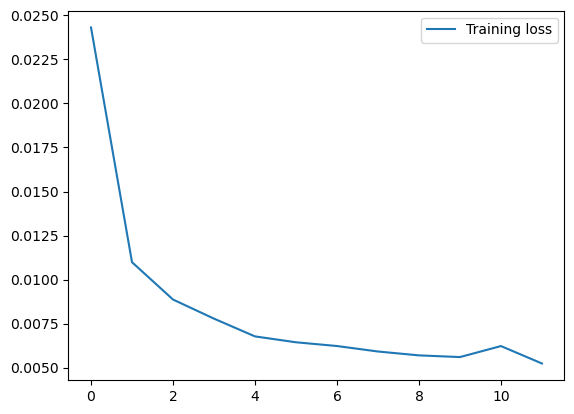

In [8]:
history = model.fit(trainX, trainY, epochs=12, batch_size=64, validation_split=0.0, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.legend()

In [9]:
clases = np.unique(trainY[:,0])
clases

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [10]:
f = lambda x: np.argwhere(x == clases)
f = np.vectorize(f)
y_real = f(testY[:,0])

In [23]:
predictions = model.predict(testX)

34/34 [==============================] - 1s 10ms/step


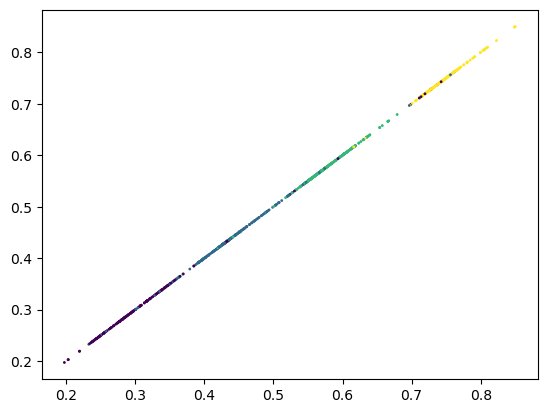

In [24]:
plt.scatter(predictions[:,0], predictions[:,0], s=1, c=y_real+1)

In [25]:
y_real_train = f(trainY[:,0])

In [26]:
predictions_train = model.predict(trainX)

128/128 [==============================] - 1s 10ms/step


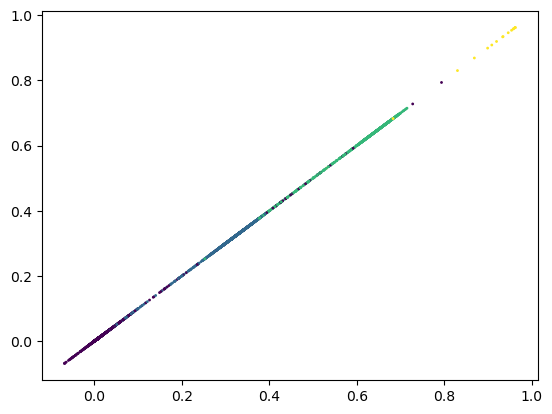

In [27]:


plt.scatter(predictions_train[:,0], predictions_train[:,0], s=1, c=y_real_train+1)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(predictions, y_real, test_size=0.3, stratify=y_real)

In [29]:
from sklearn.linear_model import LogisticRegression
rl = LogisticRegression(random_state=0, penalty=None).fit(X_train, y_train)

In [30]:
pred_test_2 = rl.predict(X_test)

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, pred_test_2))
print(classification_report(y_test, pred_test_2))

[[49  6  1  3]
 [ 3 89  6  1]
 [ 0  7 98  0]
 [ 0  0  6 51]]
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        59
           1       0.87      0.90      0.89        99
           2       0.88      0.93      0.91       105
           3       0.93      0.89      0.91        57

    accuracy                           0.90       320
   macro avg       0.91      0.89      0.90       320
weighted avg       0.90      0.90      0.90       320

